In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
params_dict_mu = {
    'input_size': 3,
    'hidden_size': 10,
    'output_size': 3,
    'ode_nn': ((50, "tanh"), (50, "tanh")),
    'readout_nn': ((50, "tanh"), (50, "tanh")),
    'enc_nn': ((50, "tanh"), (50, "tanh")),
    'use_rnn': False,
    'options': {'which_loss': 'easy'},
    "input_coords": np.arange(3),
    "output_coords": np.arange(3),
    "signature_coords": np.arange(3)
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from models import get_ckpt_model, NJODE
model_mu = NJODE(**params_dict_mu).to(device)
optimizer = torch.optim.Adam(model_mu.parameters())
get_ckpt_model("../data/saved_models/id-51/last_checkpoint/", model_mu, optimizer, device)
model_mu.eval()

using loss: easy
neuralODE use input scaling with tanh
use residual network: input_size=3, output_size=10
use residual network: input_size=10, output_size=3


NJODE(
  (ode_f): ODEFunc(
    (f): Sequential(
      (0): Linear(in_features=15, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=50, out_features=10, bias=True)
    )
  )
  (encoder_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=3, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=50, out_features=10, bias=True)
    )
  )
  (readout_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=10, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
 

In [19]:
params_dict_vol = {
    'input_size': 9,
    'hidden_size': 10,
    'output_size': 9,
    'ode_nn': ((50, "tanh"), (50, "tanh")),
    'readout_nn': ((50, "tanh"), (50, "tanh")),
    'enc_nn': ((50, "tanh"), (50, "tanh")),
    'use_rnn': False,
    'options': {'which_loss': 'easy_vol'},
    "input_coords": np.arange(9),
    "output_coords": np.arange(9),
    "signature_coords": np.arange(9)
}
model_vol = NJODE(**params_dict_vol).to(device)
optimizer_vol = torch.optim.Adam(model_vol.parameters())
get_ckpt_model("../data/saved_models/id-55/last_checkpoint/", model_vol, optimizer_vol, device)
model_vol.eval()

using loss: easy_vol
neuralODE use input scaling with tanh
use residual network: input_size=9, output_size=10
use residual network: input_size=10, output_size=9


NJODE(
  (ode_f): ODEFunc(
    (f): Sequential(
      (0): Linear(in_features=21, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=50, out_features=10, bias=True)
    )
  )
  (encoder_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=9, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=50, out_features=10, bias=True)
    )
  )
  (readout_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=10, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
 

In [20]:
mu_data=np.load("../data/training_data/OrnsteinUhlenbeckMultiDimensional-46/data.npy")

In [21]:
 def generate_next_value( X_t, mu_t, sigma_t, delta_t):
    """
    Generate the next value in the time series using the Euler-Maruyama scheme.

    :param X_t: current value tensor of shape (batch_size, d)
    :param mu_t: drift coefficient tensor of shape (batch_size, d)
    :param sigma_t: diffusion coefficient tensor of shape ( d, d)
    :param delta_t: time difference float
    :return: next value tensor of shape (batch_size, d)
    """
    delta_Wt = torch.randn_like(X_t) * delta_t** 0.5

    X_t_next = X_t + mu_t * delta_t + delta_Wt @ sigma_t

    return X_t_next

In [34]:
times=np.array([])
time_ptr = np.array([0])
obs_idx = torch.tensor([],dtype=torch.long)
start_Z = torch.tensor(np.zeros((9,)), dtype=torch.float).unsqueeze(0)
Z = torch.tensor(np.zeros((9,)), dtype=torch.float).unsqueeze(0)
delta_t=0.01
X= torch.tensor(mu_data[0,:,0], dtype=torch.float).unsqueeze(0)
start_X = torch.tensor(mu_data[0,:,0], dtype=torch.float).unsqueeze(0)
n_obs_ot=torch.tensor([0], dtype=torch.float)

first_term = torch.tensor([], dtype=torch.float) 
second_term = torch.tensor([], dtype=torch.float)
third_term = torch.tensor([], dtype=torch.float)

for i in range(1,101): 
    T=0.01*i
    mu_pred=model_mu.get_pred(times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot)["pred"][-1] 
    #print(model_mu.get_pred(times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot))
    X_t = X[i-1,:].unsqueeze(0) 
    if i>1: 
        X_t_minus = X[i-2, :].unsqueeze(0)
        Z_tensor = (X_t - X_t_minus).T@(X_t-X_t_minus)
        Z=torch.cat((Z,Z_tensor.view(1,-1)))
    #print(Z)
    
    sigma_pred=model_vol.get_pred(times, time_ptr, Z, obs_idx, delta_t, T, start_Z, n_obs_ot )["pred"][-1]
    
    #print(model_vol.get_pred(times, time_ptr, Z, obs_idx, delta_t, T, start_Z, n_obs_ot ))
    mu_hat_t = (mu_pred - X_t)/delta_t
    
    #sigma_hat_t = torch.linalg.cholesky(sigma_pred.view(3,3))/(delta_t**0.5)
    #X_next = generate_next_value(X_t, mu_hat_t, sigma_hat_t, delta_t)
    sigma_hat_t = sigma_pred/(delta_t**0.5)
    X_next = generate_next_value(X_t, mu_hat_t, sigma_hat_t.view(3,3), delta_t)
    
    
    
    first_term = torch.cat((first_term,X_t))
    second_term = torch.cat((second_term,mu_hat_t*delta_t))
    third_term = torch.cat((third_term,torch.randn_like(X_t)@sigma_hat_t.view(3,3)*delta_t**0.5))
    
    X= torch.cat((X,X_next))
    times=np.append(times, 0.01*i)
    time_ptr = np.append(time_ptr, i) 
    obs_idx=torch.cat((obs_idx, torch.tensor([0], dtype=torch.long)))
    n_obs_ot+=1

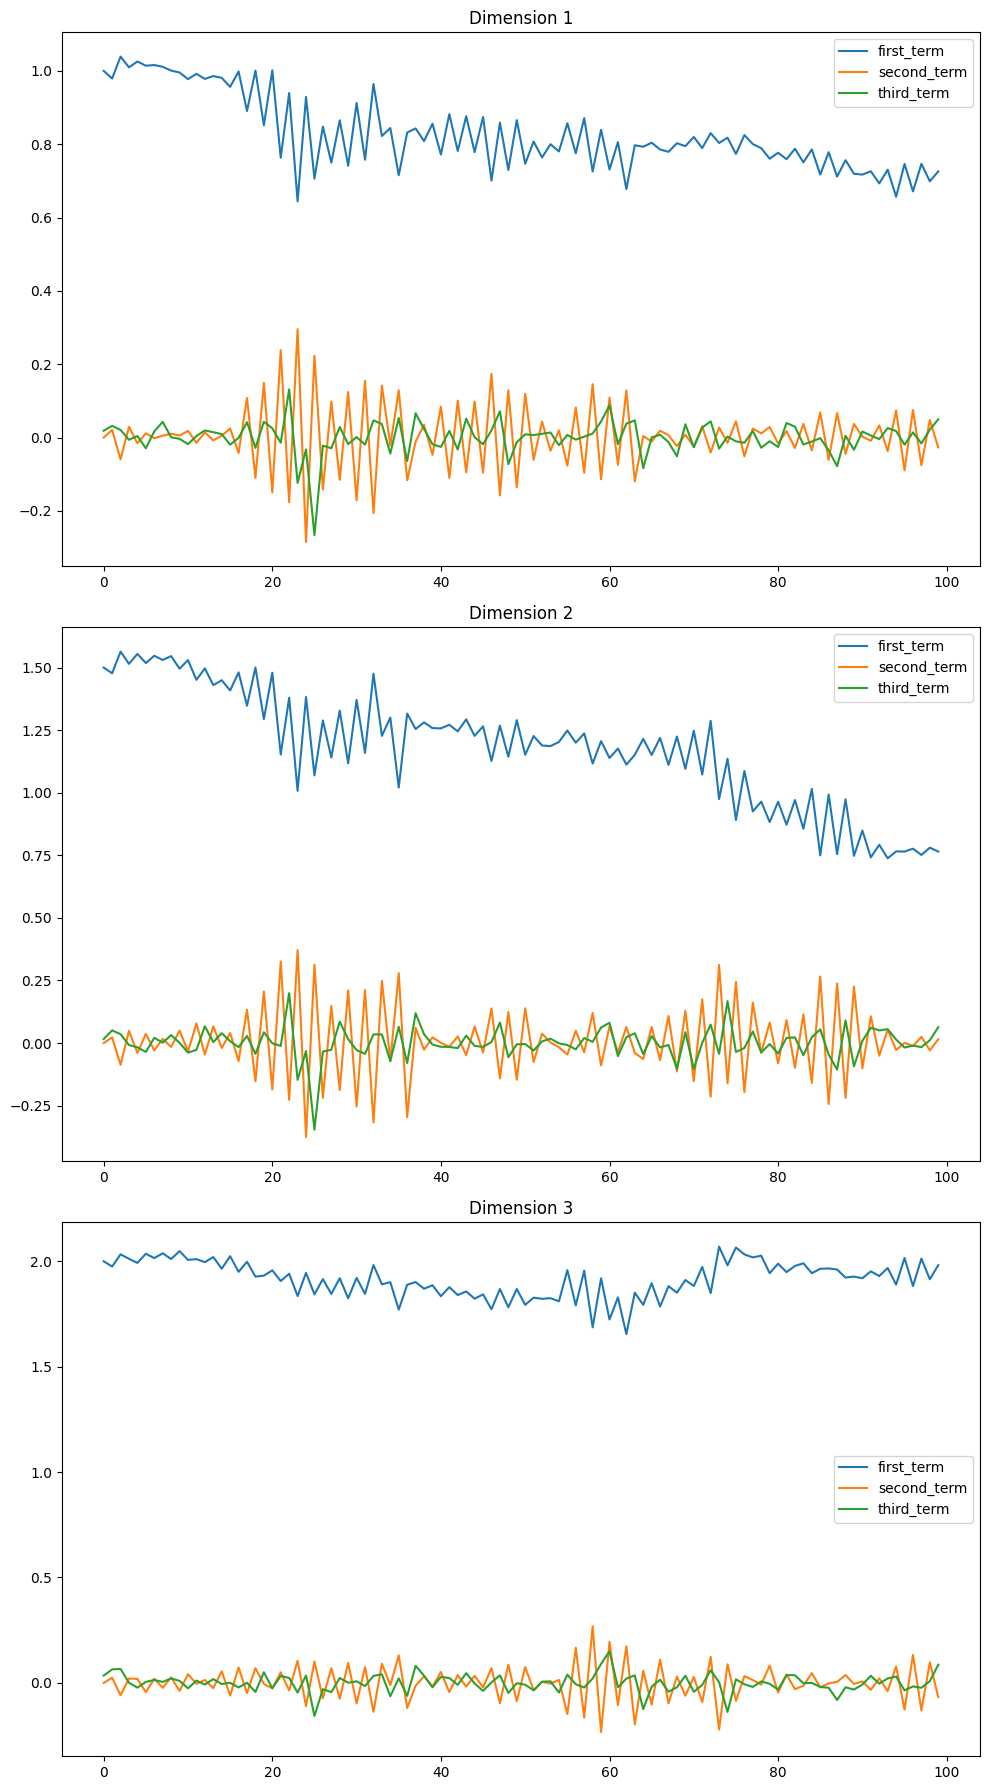

In [38]:
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

for i in range(3):
    axs[i].plot(first_term[:, i].detach().numpy(), label='first_term')
    axs[i].plot(second_term[:,i].detach().numpy(), label='second_term')
    axs[i].plot(third_term[:,i].detach().numpy(), label='third_term')
    axs[i].legend()
    axs[i].set_title(f'Dimension {i + 1}')

plt.tight_layout()
plt.show()

In [36]:
X

tensor([[1.0000, 1.5000, 2.0000],
        [0.9793, 1.4770, 1.9751],
        [1.0390, 1.5637, 2.0329],
        [1.0097, 1.5148, 2.0115],
        [1.0256, 1.5545, 1.9922],
        [1.0141, 1.5179, 2.0357],
        [1.0160, 1.5470, 2.0151],
        [1.0112, 1.5301, 2.0376],
        [1.0008, 1.5458, 2.0107],
        [0.9956, 1.4954, 2.0479],
        [0.9775, 1.5297, 2.0064],
        [0.9920, 1.4509, 2.0099],
        [0.9781, 1.4967, 1.9957],
        [0.9859, 1.4298, 2.0200],
        [0.9810, 1.4494, 1.9645],
        [0.9565, 1.4088, 2.0239],
        [0.9985, 1.4807, 1.9498],
        [0.8906, 1.3477, 1.9976],
        [1.0008, 1.5003, 1.9271],
        [0.8520, 1.2939, 1.9317],
        [1.0016, 1.4792, 1.9568],
        [0.7632, 1.1528, 1.9061],
        [0.9398, 1.3794, 1.9407],
        [0.6441, 1.0074, 1.8351],
        [0.9291, 1.3826, 1.9451],
        [0.7062, 1.0692, 1.8431],
        [0.8481, 1.2885, 1.9155],
        [0.7499, 1.1404, 1.8451],
        [0.8652, 1.3279, 1.9196],
        [0.741

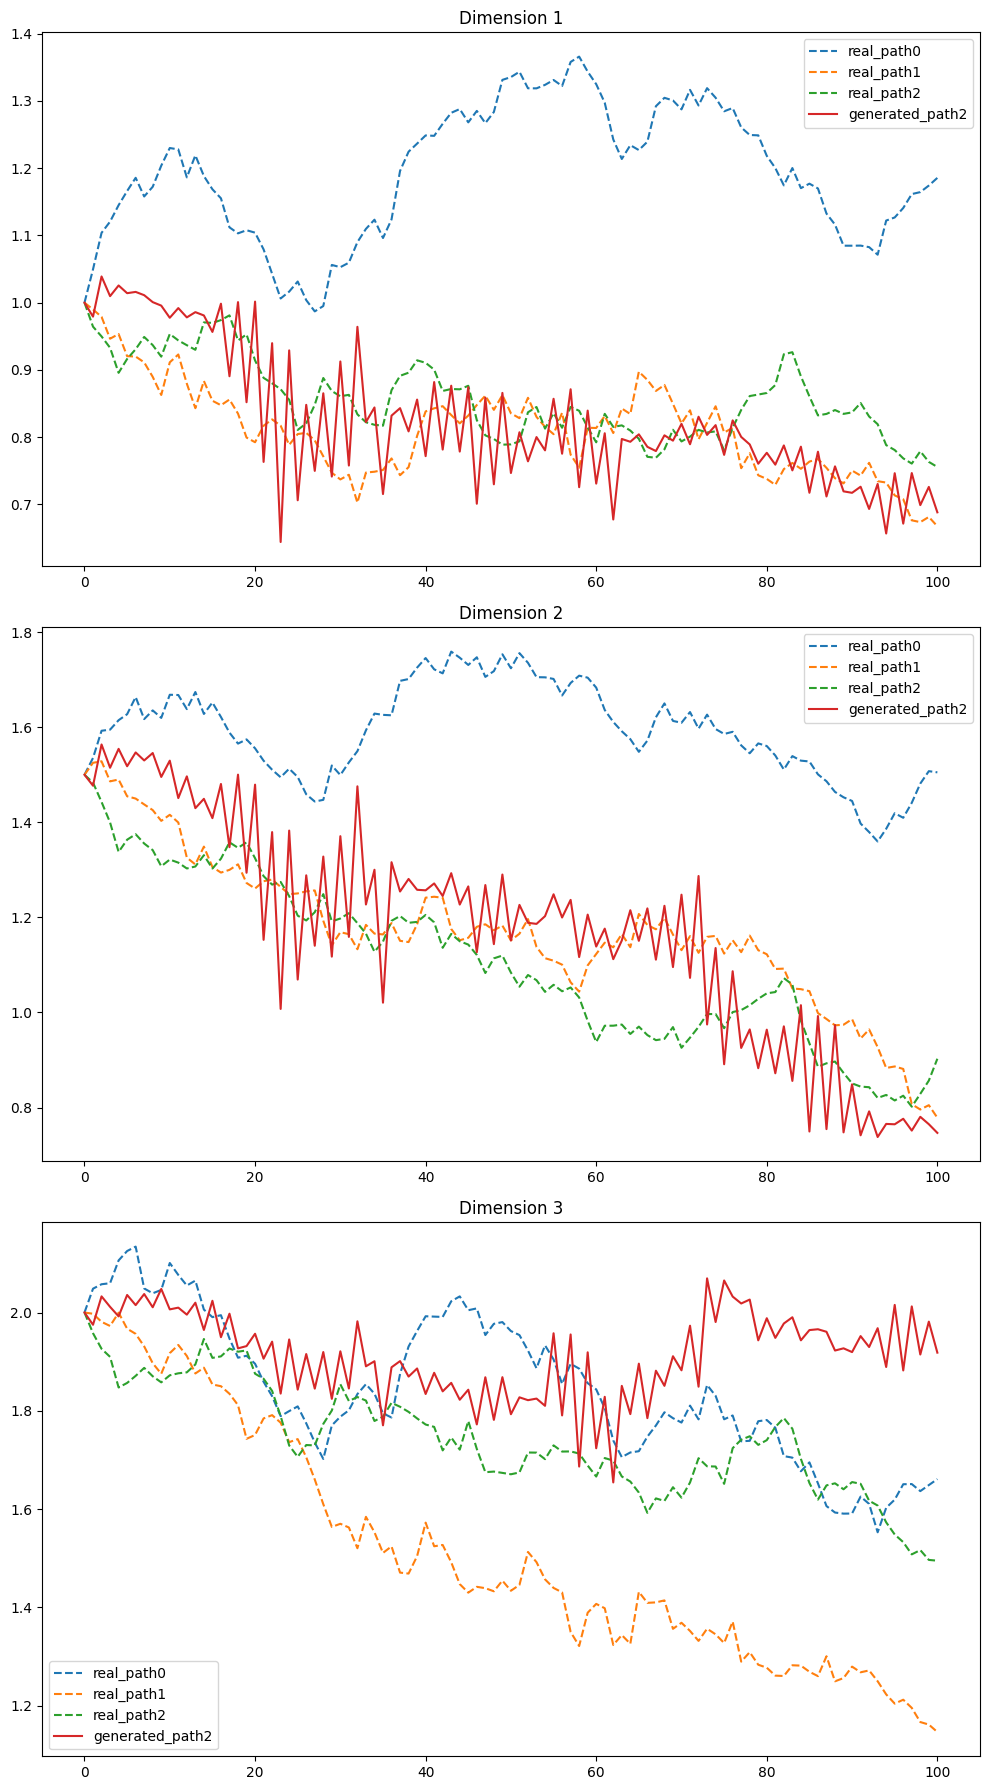

In [37]:
# Plotting each dimension separately
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

for i in range(3):
    real_path = mu_data[:, i, :].T
    generated_path = X[:, i]

    for j in range(3):
        axs[i].plot(real_path[:, j], label=f'real_path{j}', linestyle="--")

    axs[i].plot(generated_path.unsqueeze(1).detach().numpy(), label=f'generated_path{j}')
    axs[i].legend()
    axs[i].set_title(f'Dimension {i + 1}')

plt.tight_layout()
plt.show()